# Investigation of PurpleAir's data
[PurpleAir](http://www.purpleair.com) sells low-cost air quality sensors that feed data to [real-time maps of PM2.5 pollution](https://www.purpleair.com/map?#11/37.789/-122.2048).   
This data will be used for a UC Berkeley capstone project [summarized here](https://docs.google.com/document/d/1NjCpqNd7rDnD6VOExVktGtquRzs21hpwZ8HhLQpYLO8/edit).

### Libraries and installs

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import json
import datetime, time
import ast
from matplotlib import pyplot as plt 
import seaborn as sns
import gmplot

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

### Data Folder Instructions

In [2]:
# Use this cell to specify the paths for the data folder in your local machines
# Use the variable 'datafolder' to specify the path
# Comment out all the data paths except your own
# Purple Air data ia assumed to be in a subfolder called 'purpleair' 
# For example, if the base data folder is '/users/data', purpleair data should be in '/users/data/purpleair'

# Angshuman's local path
datafolder = "/Users/apaul2/Documents/_Common/capstone/Project/data"

### Get sample data

A list of sensors to download csv data individually from is here: https://www.purpleair.com/sensorlist  
Another option is to curl or otherwise read in this URL to get the JSON file for all sensors: https://www.purpleair.com/json

#### JSON data fields and their values

In [ ]:
"ID":1234, // PurpleAir sensor ID
"ParentID":null, // The PurpleAir sensor ID of the "parent" entry in the case of Channel B
"THINGSPEAK_PRIMARY_ID":"1234", // The Thingspeak channel ID for primary data of this sensor
"THINGSPEAK_PRIMARY_ID_READ_KEY":"XXXX", // The Thingspeak read key for primary data of this sensor
"Label":"name", // The "name" that appears on the map for this sensor
"Lat":null, // Latitude position info
"Lon":null, // Longitude position info
"PM2_5Value":"1.07", // Current PM2.5 value (based on the 
"State":null,  // Unused variable
"Type":"TYPE",  // Sensor type (PMS5003, PMS1003, BME280 etc)
"Hidden":"true", // Hide from public view on map: true/false
"Flag":null, // Data flagged for unusually high readings
"DEVICE_BRIGHTNESS":"1", // LED brightness (if hardware is present)
"isOwner":1, // Currently logged in user is the sensor owner
"A_H":null, // true if the sensor output has been downgraded or marked for attention due to suspected hardware issues
"temp_f":"xx",  // Current temperature in F
"humidity":"xx", // Current humidity in %
"pressure":"xx", // Current pressure in Millibars
"AGE":29831, // Sensor data age (when data was last received) in minutes
"THINGSPEAK_SECONDARY_ID":"1234", // The Thingspeak channel ID for secondary data of this sensor
"THINGSPEAK_SECONDARY_ID_READ_KEY":"XXXX", // The Thingspeak read key for secondary data of this sensor
"LastSeen":1490309930, // Last seen data time stamp in UTC
"Version":"2.47c", // Current version of sensor firmware
"LastUpdateCheck":1490308331, // Last update checked at time stamp in UTC
"Uptime":"5210", // Sensor uptime in seconds
"RSSI":"-68", // Sensor's WiFi signal strength in dBm

"Stats": // Statistics for PM2.5

"{
\"v\":1.07, // Real time or current PM2.5 Value
\"v1\":1.3988595758168765, // Short term (10 minute average)
\"v2\":10.938131480857114, // 30 minute average
\"v3\":15.028685608345926, // 1 hour average
\"v4\":6.290537580116773, // 6 hour average
\"v5\":1.8393146177050788, // 24 hour average
\"v6\":0.27522764912064507, // One week average
\"pm\":1.07, // Real time or current PM2.5 Value
\"lastModified\":1490309930933, // Last modified time stamp for calculated average statistics
\"timeSinceModified\":69290 // Time between last two readings in milliseconds
}"
}

#### Load data into dataframe
This will take about a minute. It is loading all publicly available sensor data for that instant.

In [3]:
sample_09141423_df = pd.read_json(path_or_buf="https://www.purpleair.com/json")

In [22]:
sample_09141423_df.to_csv("{}/purpleair/09141423.csv".format(datafolder))

### Initial look at the data


In [4]:
sample_09141423_df.head()

,Unnamed: 0,baseVersion,mapVersion,mapVersionString,results
0,0,6,0.88,NaN,"{'ID': 24115, 'Label': ' 2nd South 12th East',..."
1,1,6,0.88,NaN,"{'ID': 24116, 'ParentID': 24115, 'Label': ' 2n..."
2,2,6,0.88,NaN,"{'ID': 27699, 'Label': ' CHA1', 'DEVICE_LOCATI..."
3,3,6,0.88,NaN,"{'ID': 27700, 'ParentID': 27699, 'Label': ' CH..."
4,4,6,0.88,NaN,"{'ID': 16791, 'Label': ' DW0435', 'DEVICE_LOCA..."


#### Put the data into better format

In [14]:
df09141423 = pd.DataFrame.from_records(sample_09141423_df.results)

In [15]:
df09141423.shape

(17542, 22)

In [16]:
# split the dict in the 'Stats' column into separate columns
df09141423['Stats'] = df09141423['Stats'].replace(np.nan, '{}', regex=True)
df09141423['Stats'] =  df09141423['Stats'].map(lambda d : ast.literal_eval(d))
df09141423 = df09141423.join(pd.DataFrame(df09141423["Stats"].to_dict()).T)
df09141423.drop(['Stats', 'pm','v'], axis=1, inplace=True)   # 'pm' and 'v' are the same as 'PM2_5Value'

In [17]:
df09141423.columns

Index(['AGE', 'A_H', 'DEVICE_LOCATIONTYPE', 'Flag', 'Hidden', 'ID', 'Label',
       'LastSeen', 'Lat', 'Lon', 'PM2_5Value', 'ParentID',
       'THINGSPEAK_PRIMARY_ID', 'THINGSPEAK_PRIMARY_ID_READ_KEY',
       'THINGSPEAK_SECONDARY_ID', 'THINGSPEAK_SECONDARY_ID_READ_KEY', 'Type',
       'humidity', 'isOwner', 'pressure', 'temp_f', 'lastModified',
       'timeSinceModified', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6'],
      dtype='object')

In [18]:
# rename columns to something easily understandable
df09141423.columns = ['age','a_h','device_loc_typ','high_reading_flag', 'hidden','sensor_id','sensor_name','last_seen','lat','lon',
                      'pm2_5val','parent_id','thingspeak_primary_id','thingspeak_primary_id_read_key','thingspeak_secondary_id',
                      'thingspeak_secondary_id_read_key','sensor_type','humidity','is_owner','pressure','temp_f','av_stat_last_modified',
                      'av_stat_time_since_last_modified','pm2_5val_10m_avg','pm2_5val_30m_avg','pm2_5val_1h_avg','pm2_5val_6h_avg',
                      'pm2_5val_24h_avg','pm2_5val_1wk_avg']

In [19]:
df09141423.head()

,age,a_h,device_loc_typ,high_reading_flag,hidden,sensor_id,sensor_name,last_seen,lat,lon,pm2_5val,parent_id,thingspeak_primary_id,thingspeak_primary_id_read_key,thingspeak_secondary_id,thingspeak_secondary_id_read_key,sensor_type,humidity,is_owner,pressure,temp_f,av_stat_last_modified,av_stat_time_since_last_modified,pm2_5val_10m_avg,pm2_5val_30m_avg,pm2_5val_1h_avg,pm2_5val_6h_avg,pm2_5val_24h_avg,pm2_5val_1wk_avg
0,357169,NaN,inside,NaN,false,24115,2nd South 12th East,1547065985,40.764907,-111.856653,0.15,NaN,672791,CLV9HLXOGIYQNYD2,672792,WAZLM3J4Q9OHKNGE,PMS5003+PMS5003+BME280,15,0,869.14,89,1.547066e+12,80079.0,0.47,19.37,34.37,16.29,4.76,0.71
1,357169,NaN,NaN,NaN,false,24116,2nd South 12th East B,1547065988,40.764907,-111.856653,NaN,24115.0,672793,UQJBDQ2XXPP73U45,672795,5G9B9E4XFL32S845,NaN,15,0,869.16,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,98830,NaN,outside,NaN,false,27699,CHA1,1562566345,37.929030,-121.940127,3.13,NaN,716094,M57A4C3IH3QFM9N6,716095,7U439FCFH7XFYY2V,PMS5003+PMS5003+BME280,26,0,995.19,74,1.562566e+12,119968.0,3.38,3.43,3.93,6.40,6.79,4.48
3,98830,NaN,NaN,NaN,false,27700,CHA1 B,1562566345,37.929030,-121.940127,3.22,27699.0,716096,9CI7CR8RAJJ4UZC7,716097,6CE24ETYNU310ABD,NaN,NaN,0,NaN,NaN,1.562566e+12,119969.0,3.44,3.52,4.08,6.69,7.13,4.76
4,1,NaN,outside,NaN,false,16791,DW0435,1568496086,18.082454,-67.039027,3.72,NaN,589048,61GKVZGTCZSBUGB5,589049,5HBLH5R8GPLM6J88,PMS5003+PMS5003+BME280,47,0,1008.46,100,1.568496e+12,119291.0,3.82,2.63,2.03,2.59,3.08,3.98


In [130]:
df09141423.dtypes

age                                   int64
a_h                                  object
device_loc_typ                       object
high_reading_flag                   float64
hidden                               object
sensor_id                             int64
sensor_name                          object
last_seen                             int64
lat                                 float64
lon                                 float64
pm2_5val                             object
parent_id                           float64
thingspeak_primary_id                object
thingspeak_primary_id_read_key       object
thingspeak_secondary_id              object
thingspeak_secondary_id_read_key     object
sensor_type                          object
humidity                             object
is_owner                              int64
pressure                             object
temp_f                               object
av_stat_last_modified               float64
av_stat_time_since_last_modified

In [20]:
# Some numeric columns have "nan" as a string - convert these values to np.nan
# so that the data type of these columns are correctly identified
df09141423[['pm2_5val','humidity','pressure','temp_f']] = df09141423[['pm2_5val','humidity','pressure','temp_f']].replace("nan", np.nan, regex=True)
df09141423[['pm2_5val','humidity','pressure','temp_f']] = df09141423[['pm2_5val','humidity','pressure','temp_f']].apply(pd.to_numeric)

In [21]:
# Convert data type of attributes to string
df09141423[['high_reading_flag','sensor_id','parent_id', 'is_owner']] = df09141423[['high_reading_flag','sensor_id','parent_id', 'is_owner']].astype(str)

In [22]:
df09141423.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17542.0,1.278906e+05,2.422500e+05,0.000000e+00,0.000000e+00,1.000000e+00,1.529770e+05,1.533576e+06
last_seen,17542.0,1.560823e+09,1.453500e+07,1.476482e+09,1.559318e+09,1.568496e+09,1.568496e+09,1.568496e+09
lat,17299.0,3.643706e+01,1.336166e+01,-5.363266e+01,3.406359e+01,3.790145e+01,4.107494e+01,7.130136e+01
lon,17299.0,-9.118415e+01,5.929597e+01,-1.617681e+02,-1.220063e+02,-1.173269e+02,-8.303098e+01,1.783003e+02
pm2_5val,16830.0,3.185784e+01,2.722975e+02,0.000000e+00,1.950000e+00,4.760000e+00,1.140000e+01,5.908730e+03
humidity,10870.0,3.564425e+01,1.881507e+01,0.000000e+00,2.200000e+01,3.400000e+01,4.800000e+01,2.550000e+02
pressure,10869.0,9.624146e+02,8.469303e+01,-2.271800e+02,9.391100e+02,9.955800e+02,1.009470e+03,1.620130e+03
temp_f,10870.0,7.936495e+01,3.761717e+01,-2.380000e+02,7.400000e+01,8.300000e+01,9.200000e+01,1.440000e+02
av_stat_last_modified,16827.0,1.560714e+12,1.469388e+10,1.476482e+12,1.559316e+12,1.568496e+12,1.568496e+12,1.568496e+12
av_stat_time_since_last_modified,16827.0,3.825264e+07,7.392224e+08,2.952000e+03,9.428800e+04,1.199830e+05,1.200380e+05,3.634860e+10


In [23]:
# describe non-numeric columns
df09141423[['a_h','device_loc_typ','high_reading_flag','hidden','sensor_id','sensor_name','parent_id','thingspeak_primary_id','thingspeak_primary_id_read_key','thingspeak_secondary_id',
                      'thingspeak_secondary_id_read_key','sensor_type','is_owner']].describe().T

,count,unique,top,freq
a_h,172,1,true,172
device_loc_typ,8473,2,outside,7206
high_reading_flag,17542,3,nan,14971
hidden,17542,1,false,17542
sensor_id,17542,17542,5062,1
sensor_name,17542,16814,Home B,16
parent_id,17542,8748,nan,8786
thingspeak_primary_id,17542,17542,395662,1
thingspeak_primary_id_read_key,17542,17542,J5R3SUG1EPRJIHT7,1
thingspeak_secondary_id,17542,17542,411472,1


In [27]:
pandas_profiling.ProfileReport(df09141423)

In [233]:
# check inside/outside distribution for sensors
df09141423.groupby('device_loc_typ').sensor_id.count()

device_loc_typ
inside     1267
outside    7206
Name: sensor_id, dtype: int64

#### Reverse Geocoding

In [31]:
# # Most geocoding techniques involving google apis require an api key
# # Trying alternative based on https://geopy.readthedocs.io/en/stable/
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="air_pol")

# location = geolocator.reverse("40.764907,-111.856653")
# location.raw
# location.raw['address']['state']

In [13]:
# def getLocation(lstItem):
#     latitude = lstItem[0]
#     longitude = lstItem[1]
# #     latitude = row['lat']
# #     longitude = row['lon']
# #     if latitude != np.nan:
#     geolocatorString = str(latitude) + ', ' + str(longitude)
#     location = geolocator.reverse(geolocatorString)
# #         country = location.raw['address']['country']
# #         state = location.raw['address']['state']
# #         city = location.raw['address']['city']
# #         zipcode = location.raw['address']['postcode']
#     return location.raw.get(["address"][0],"")

# # # Applying the function to dataframe times out
# # rslt = getLocation(df09141423.loc[0,:])
# # print(rslt)

# # time.sleep(20)
# # dwtest['address'] = dwtest.apply(getLocation, axis=1)

In [41]:
## ****** USING GOOGLE API - This works but Geocoder appears to be better ********
# import urllib3
# import json

# https = urllib3.PoolManager()

# def getLocation(lat, lon):
#     url = "https://maps.googleapis.com/maps/api/geocode/json?"
#     url += "latlng=%s,%s&sensor=false&key=XXXX" % (lat, lon)
#     try:
#         r = https.request('GET', url)
#         j = json.loads(r.data.decode('utf-8'))
#         components = j['results'][0]['address_components']
#         country = town = None
#         for c in components:
#             if "country" in c['types']:
#                 country = c['long_name']
#             if "administrative_area_level_1" in c['types']:
#                 state = c['long_name']
#             if "administrative_area_level_2" in c['types']:
#                 county = c['long_name']
#             if "locality" in c['types']:
#                 city = c['long_name']
#             if "postal_code" in c['types']:
#                 zipcode = c['long_name']
#         return {"country" : country, "state" : state, "county" : county, "city" : city, "zipcode" : zipcode}
#     except:
#         return {}
# print(getLocation(40.764907, -111.856653))

In [56]:
# Read data file
sample_09141731_df = pd.read_csv("{}/purpleair/09141731.csv".format(datafolder))
df09141731 = getDataframe(sample_09141731_df)

In [83]:
# ****** USING GOOGLE API - This works but Geocoder appears to be better ********
from pygeocoder import Geocoder
myGeocoder = Geocoder(api_key='')

def getLocation(lat, lon):
    try:
        results = myGeocoder.reverse_geocode(lat, lon)
        try:
            country = results.country
        except:
            country = ""
        try:
            state = results.administrative_area_level_1
        except:
            state = ""
        try:
            county = results.administrative_area_level_2
        except:
            county = ""
        try:
            city = results.locality
        except:
            city = ""
        try:
            zipcode = results.postal_code
        except:
            zipcode = ""
        return {"lat": lat, "lon": lon, "country" : country, "state" : state, "county" : county, "city" : city, "zipcode" : zipcode}
    except:
        return {"lat": lat, "lon": lon, "country" : "", "state" : "", "county" : "", "city" : "", "zipcode" : ""}

In [32]:
# create unique lat and long list from the dataframe
# so that we dont make duplicate api calls
lat_lon_list = []
for row in range(len(df09141731)):
    try:
        if len(str(df09141731.iloc[row].lat).strip()) > 3:
            lat_lon_list.append((df09141731.iloc[row].lat, df09141731.iloc[row].lon))
    except:
        pass
    
lat_lon_list = list(set(lat_lon_list))

In [96]:
# Get addresses in a new list
lat_lon_list_new = []
for item in lat_lon_list:
    address = getLocation(item[0], item[1])
    lat_lon_list_new.append(address)
    
len(lat_lon_list_new)

8563

In [97]:
# Create dataframe with address details
address_df = pd.DataFrame(lat_lon_list_new)
address_df.head()

,city,country,county,lat,lon,state,zipcode
0,Kardia,Greece,None,40.465755,22.992308,None,575 00
1,Thessaloniki,Greece,None,40.633926,22.956742,None,546 36
2,Thessaloniki,Greece,None,40.597275,22.954437,None,546 46
3,Thessaloniki,Greece,None,40.629482,22.966246,None,546 36
4,Keizer,United States,Marion County,45.017528,-123.016639,Oregon,97303


In [99]:
# Join address dataframe with main dataframe
df09141731 = pd.merge(df09141731, address_df,  how='left', left_on=['lat','lon'], right_on=['lat','lon'])
df09141731.head()

,age,a_h,device_loc_typ,high_reading_flag,hidden,sensor_id,sensor_name,last_seen,lat,lon,pm2_5val,parent_id,thingspeak_primary_id,thingspeak_primary_id_read_key,thingspeak_secondary_id,thingspeak_secondary_id_read_key,sensor_type,humidity,is_owner,pressure,temp_f,av_stat_last_modified,av_stat_time_since_last_modified,pm2_5val_10m_avg,pm2_5val_30m_avg,pm2_5val_1h_avg,pm2_5val_6h_avg,pm2_5val_24h_avg,pm2_5val_1wk_avg,city,country,county,state,zipcode
0,357358,NaN,inside,nan,false,24115,2nd South 12th East,1547065985,40.764907,-111.856653,0.15,nan,672791,CLV9HLXOGIYQNYD2,672792,WAZLM3J4Q9OHKNGE,PMS5003+PMS5003+BME280,15.0,0,869.14,89.0,1.547066e+12,80079.0,0.47,19.37,34.37,16.29,4.76,0.71,Salt Lake City,United States,Salt Lake County,Utah,84102
1,357358,NaN,NaN,nan,false,24116,2nd South 12th East B,1547065988,40.764907,-111.856653,NaN,24115.0,672793,UQJBDQ2XXPP73U45,672795,5G9B9E4XFL32S845,NaN,15.0,0,869.16,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Salt Lake City,United States,Salt Lake County,Utah,84102
2,99019,NaN,outside,nan,false,27699,CHA1,1562566345,37.929030,-121.940127,3.13,nan,716094,M57A4C3IH3QFM9N6,716095,7U439FCFH7XFYY2V,PMS5003+PMS5003+BME280,26.0,0,995.19,74.0,1.562566e+12,119968.0,3.38,3.43,3.93,6.40,6.79,4.48,Clayton,United States,Contra Costa County,California,94517
3,99019,NaN,NaN,nan,false,27700,CHA1 B,1562566345,37.929030,-121.940127,3.22,27699.0,716096,9CI7CR8RAJJ4UZC7,716097,6CE24ETYNU310ABD,NaN,NaN,0,NaN,NaN,1.562566e+12,119969.0,3.44,3.52,4.08,6.69,7.13,4.76,Clayton,United States,Contra Costa County,California,94517
4,0,NaN,outside,nan,false,16791,DW0435,1568507486,18.082454,-67.039027,1.47,nan,589048,61GKVZGTCZSBUGB5,589049,5HBLH5R8GPLM6J88,PMS5003+PMS5003+BME280,58.0,0,1009.83,96.0,1.568507e+12,119763.0,1.78,1.53,1.51,2.29,2.97,3.95,San Germán,Puerto Rico,San Germán,None,00683


In [100]:
# Save daaframe with location information for future use
df09141731.to_csv("{}/purpleair/09141731_withaddress.csv".format(datafolder))

In [8]:
# df09141731 = pd.read_csv("{}/purpleair/09141731_withaddress.csv".format(datafolder))
# df09141731.head()

In [9]:
# Number of countries for which we have sensor data
len(df09141731.groupby('country'))

105

In [149]:
# Number of sensors by country
country_df = df09141731.groupby('country')['sensor_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
country_df

,country,count
102,United States,13965
20,Canada,927
46,India,288
4,Australia,212
39,Greece,182


In [107]:
# Number of sensors by US states
state_df = df09141731[df09141731.country == 'United States'].groupby('state')['sensor_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
state_df

,state,count
4,California,6821
44,Utah,1213
47,Washington,598
37,Oregon,520
43,Texas,492


In [112]:
# Number of sensors by US cities overall
city_df = df09141731[(df09141731.country == 'United States')].groupby('city')['sensor_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
city_df

,city,count
829,Los Angeles,502
1293,San Francisco,394
1156,Pittsburgh,221
69,Austin,217
1284,Salt Lake City,217


In [111]:
# Number of sensors by California cities
city_df = df09141731[(df09141731.country == 'United States') & (df09141731.state == 'California')].groupby('city')['sensor_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
city_df

,city,count
292,Los Angeles,502
458,San Francisco,394
47,Berkeley,206
439,Riverside,176
450,Sacramento,170


In [15]:
# Correlation among numeric attributes
num_df = df09141731.loc[:,['pm2_5val', 'humidity', 'pressure', 'temp_f']]
corr = num_df.corr()

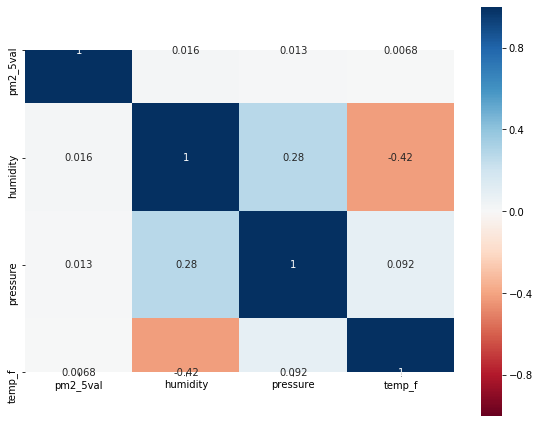

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr,  annot=True,  vmin=-1, vmax=1, ax=ax,  cmap="RdBu", square=True)
fig.tight_layout()
plt.show()

#### Download additional data files

In [6]:
def getDataframe(dfFromFile):
    """Helper function to format the downloaded data into a more usable dataframe"""
    
    # create dataframe from the 'results' column
    dfFromFile['results'] =  dfFromFile['results'].map(lambda d : ast.literal_eval(d))
    df = pd.DataFrame.from_records(dfFromFile.results)

    # split the dict in the 'Stats' column into separate columns
    df['Stats'] = df['Stats'].replace(np.nan, '{}', regex=True)
    df['Stats'] =  df['Stats'].map(lambda d : ast.literal_eval(d))
    df = df.join(pd.DataFrame(df["Stats"].to_dict()).T)
    df.drop(['Stats', 'pm','v'], axis=1, inplace=True)   # 'pm' and 'v' are the same as 'PM2_5Value'

    # rename columns to something easily understandable
    df.columns = ['age','a_h','device_loc_typ','high_reading_flag', 'hidden','sensor_id','sensor_name','last_seen','lat','lon',
                          'pm2_5val','parent_id','thingspeak_primary_id','thingspeak_primary_id_read_key','thingspeak_secondary_id',
                          'thingspeak_secondary_id_read_key','sensor_type','humidity','is_owner','pressure','temp_f','av_stat_last_modified',
                          'av_stat_time_since_last_modified','pm2_5val_10m_avg','pm2_5val_30m_avg','pm2_5val_1h_avg','pm2_5val_6h_avg',
                          'pm2_5val_24h_avg','pm2_5val_1wk_avg']

    # Some numeric columns have "nan" as a string - convert these values to np.nan
    # so that the data type of these columns are correctly identified
    df[['pm2_5val','humidity','pressure','temp_f']] = df[['pm2_5val','humidity','pressure','temp_f']].replace("nan", np.nan, regex=True)
    df[['pm2_5val','humidity','pressure','temp_f']] = df[['pm2_5val','humidity','pressure','temp_f']].apply(pd.to_numeric)

    # Convert data type of attributes to string
    df[['high_reading_flag','sensor_id','parent_id', 'is_owner']] = df[['high_reading_flag','sensor_id','parent_id', 'is_owner']].astype(str)
    
    return df


In [5]:
# # download files 1 min apart
# for i in range(2):
#     datetimeval = datetime.datetime.now().strftime("%Y%m%d%H%M")
#     filename = "/Users/apaul2/Documents/_Common/capstone/Project/data/PurpleAir/" + str(datetimeval) + ".csv"
#     time.sleep(60)
#     purple_df = pd.read_json(path_or_buf="https://www.purpleair.com/json")
#     purple_df.to_csv(filename)
# download files 5 min apart
# while True:
#     datetimeval = datetime.datetime.now().strftime("%Y%m%d%H%M")
#     filename = "/Users/apaul2/Documents/_Common/capstone/Project/data/PurpleAir/" + str(datetimeval) + ".csv"
#     time.sleep(300)
#     purple_df = pd.read_json(path_or_buf="https://www.purpleair.com/json")
#     purple_df.to_csv(filename)
# # download files 10 min apart
# for i in range(3):
#     timeval += 10
#     filename = "/Users/apaul2/Documents/_Common/capstone/Project/data/PurpleAir/" + str(datetimeval) + ".csv"
#     time.sleep(600)
#     purple_df = pd.read_json(path_or_buf="https://www.purpleair.com/json")
#     purple_df.to_csv(filename)

In [3]:
sample_09141423_df = pd.read_csv("{}/purpleair/09141423.csv".format(datafolder))
sample_09151453_df = pd.read_csv("{}/purpleair/09151453.csv".format(datafolder))
sample_09151454_df = pd.read_csv("{}/purpleair/09151454.csv".format(datafolder))
sample_09151459_df = pd.read_csv("{}/purpleair/09151459.csv".format(datafolder))
sample_09151504_df = pd.read_csv("{}/purpleair/09151504.csv".format(datafolder))
sample_09151529_df = pd.read_csv("{}/purpleair/09151529.csv".format(datafolder))
sample_09151609_df = pd.read_csv("{}/purpleair/09151609.csv".format(datafolder))

In [7]:
# Get data in more usable format
df09141423 = getDataframe(sample_09141423_df)
df09151453 = getDataframe(sample_09151453_df)
df09151454 = getDataframe(sample_09151454_df)
df09151459 = getDataframe(sample_09151459_df)
df09151504 = getDataframe(sample_09151504_df)
df09151529 = getDataframe(sample_09151529_df)
df09151609 = getDataframe(sample_09151609_df)

#### Check difference in sensors after different intervals

In [127]:
def sensorDiff(df1, df2):
    counter = 0
    sensor_diff = len(df2) - len(df1)
    num_sensors = len(df2)
    for row in range(num_sensors):
        if df1.last_seen[row] != df2.last_seen[row]:
            counter += 1
    return num_sensors, sensor_diff, counter

In [132]:
# Difference after 1 minute
num_sensors, sensor_diff, counter = sensorDiff(df09151453, df09151454)
print("There are", num_sensors, "sensors total, of which ", sensor_diff, " were added in the last minute and", counter, "have new data after 1 minute.")

There are 17548 sensors total, of which  0  were added in the last minute and 5805 have new data after 1 minute.


In [128]:
# Difference after 5 minutes
num_sensors, sensor_diff, counter = sensorDiff(df09151454, df09151459)
print("There are", num_sensors, "sensors total, of which ", sensor_diff, " were added in the last 5 minutes and", counter, "have new data after 5 minutes.")

There are 17548 sensors total, of which  0  were added in the last 5 minutes and 10224 have new data after 5 minutes.


In [133]:
# Difference after 10 minutes
num_sensors, sensor_diff, counter = sensorDiff(df09151454, df09151504)
print("There are", num_sensors, "sensors total, of which ", sensor_diff, " were added in the last 10 minutes and", counter, "have new data after 10 minutes.")

There are 17548 sensors total, of which  0  were added in the last 10 minutes and 10244 have new data after 10 minutes.


In [135]:
# Difference after 30 minutes
num_sensors, sensor_diff, counter = sensorDiff(df09151459, df09151529)
print("There are", num_sensors, "sensors total, of which ", sensor_diff, " were added in the last 30 minutes and", counter, "have new data after 30 minutes.")

There are 17548 sensors total, of which  0  were added in the last 30 minutes and 10276 have new data after 30 minutes.


In [136]:
# Difference after 1 hour
num_sensors, sensor_diff, counter = sensorDiff(df09151504, df09151609)
print("There are", num_sensors, "sensors total, of which ", sensor_diff, " were added in the last hour and", counter, "have new data after 1 hour.")

There are 17548 sensors total, of which  0  were added in the last hour and 10296 have new data after 1 hour.


In [143]:
# Number of sensors added in a day
len(df09151453) - len(df09141423)

6

#### So how often do they update?

In [20]:
df0454 = pd.read_json(path_or_buf="https://www.purpleair.com/json")
df0454pm = pd.DataFrame.from_records(df0454.results)

In [59]:
seconds = []
PM_records = df0454pm['Stats']
for PM_record in PM_records:
    if type(PM_record) == str:
        PM_record = eval(PM_record)
        if 'timeSinceModified' in PM_record.keys():
            seconds.append(PM_record['timeSinceModified']/1000)

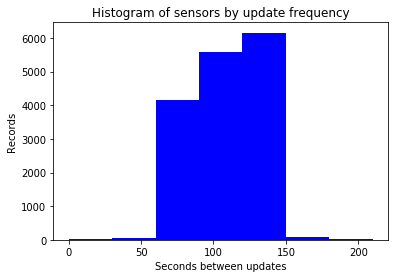

In [71]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(seconds, [0, 30, 60, 90, 120, 150, 180, 210], facecolor='blue')
plt.xlabel('Seconds between updates')
plt.ylabel('Records')
plt.title('Histogram of sensors by update frequency')
plt.show()

#### Plot datapoints on map

In [36]:
# create lat and long list from the dataframe
# stores output in an html file that you then open
# the google map will be shaded unless you've set up API key (see below)

latitude_list = []
longitude_list = []
for row in range(len(df09141731)):
    try:
        latitude_list.append(df09141731.loc[row].lat)
        longitude_list.append(df09141731.loc[row].lon)
    except:
        pass
    
# scatter points on a google map
gmap3 = gmplot.GoogleMapPlotter(latitude_list[0], longitude_list[0], 13)
gmap3.scatter(latitude_list, longitude_list, '# FF0000', 
                              size = 40, marker = False ) 
  
gmap3.draw("data/purpleair_map.html")

In [39]:
# Need to fix with an API key.
# https://console.cloud.google.com/google/maps-apis/new?project=composite-drive-193303&folder&organizationId
# how to get an API key:
# https://developers.google.com/maps/documentation/geocoding/get-api-key

gmap3 = gmplot.GoogleMapPlotter(latitude_list[0], longitude_list[0], 25)
gmap3.scatter(latitude_list, longitude_list, '# FF0000', 
                              size = 40, marker = False ) 
gmap3.apikey = "" # this is Ben's key. replace with your own.
gmap3.draw("data/purpleair_map.html") 

### Conclusions

* There are ample sensors in major metropolitan areas in order to do some sensor inference. Rural areas are weak. So we might want to either focus our tool on one city area, or define some critical mass and only generate inferences in those areas. 
* There is an ample number of sensors that are outputting new data to the network at least every five minutes. But there are very few doing so after one minute. (Most seem to update in the range of every 80 - 120 seconds.) Since the wind data from NOAA is either one minute or five minute intervals, we should grab data from both NOAA and PurpleAir at five minute intervals.
